<a href="https://colab.research.google.com/github/SamDuffield/mocat/blob/master/examples/twodim_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade mocat

In [2]:
from jax import numpy as jnp, random
import matplotlib.pyplot as plt
import mocat
%matplotlib inline
plt.style.use('fast')

In [3]:
plt.rcParams['figure.dpi'] = 100

# Define the scenario


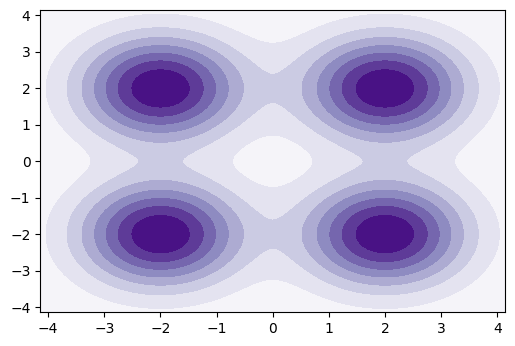

In [4]:
scenario = mocat.twodim.GaussianMixture()
scenario.plot(potential=False);

# Decide on some samplers and their parameters


Robbins-Monro update to tune stepsize to desired acceptance rate (with ```log_update=True```)
$$
  \log(h_t) = \log(h_{t-1}) - \gamma_t (\alpha^* - \alpha_t)
$$
$$
  \gamma_t = a t^{-b}
$$
$h_t$: ```parameters.stepsize```

$\alpha^*$: ```sampler.tuning.target```

$a$: ```rm_stepsize_scale```

$b$: ```rm_stepsize_neg_exponent``` 


In [5]:
correction = mocat.RMMetropolis(adapt_cut_off=jnp.inf,
                                rm_stepsize_scale=1.0,
                                rm_stepsize_neg_exponent=0.75,
                                log_update=True)

In [6]:
rwmh = mocat.RandomWalk()
mala = mocat.Overdamped()
hmc = mocat.HMC(leapfrog_steps=10)
underdamped = mocat.Underdamped(leapfrog_steps=1, friction=1.0)

samplers = [rwmh, mala, hmc, underdamped]

In [7]:
random_key = random.PRNGKey(0)

In [8]:
n = int(1e6)
n_burnin = 1000

# Run MCMC!

In [9]:
samples = []
for sampler in samplers:
  run = mocat.run(scenario,
                          sampler,
                          n + n_burnin,
                          random_key,
                          correction=correction)[n_burnin:]
  samples.append(run)

# Print some run metrics

In [10]:
def print_summary(metric_func, dp=3):
  for samp in samples:
    print(f'{samp.summary.sampler:>12}: {metric_func(samp):>12.{dp}}')

In [11]:
print('Time')
print_summary(lambda samp: samp.time)

Time
 Random Walk:         1.71
  Overdamped:         1.91
         HMC:         4.15
 Underdamped:         2.33


In [12]:
print('Target Acceptance Rate')
print_summary(lambda samp: samp.summary.tuning.target)

Target Acceptance Rate
 Random Walk:        0.234
  Overdamped:        0.574
         HMC:        0.651
 Underdamped:        0.651


In [13]:
print('Empirical Acceptance Rate')
print_summary(lambda samp: samp.alpha.mean(), 4)

Empirical Acceptance Rate
 Random Walk:        0.234
  Overdamped:        0.574
         HMC:       0.6511
 Underdamped:       0.6511


In [14]:
print('ESS')
print_summary(lambda samp: mocat.ess_autocorrelation(samp))

ESS
 Random Walk:     9.85e+04
  Overdamped:     3.75e+05
         HMC:     1.22e+05
 Underdamped:     4.23e+05


In [15]:
print('ESS/s')
print_summary(lambda samp: mocat.ess_autocorrelation(samp)/samp.time)

ESS/s
 Random Walk:     5.77e+04
  Overdamped:     1.96e+05
         HMC:     2.94e+04
 Underdamped:     1.81e+05


In [16]:
print('Empirical Squared Jumping Distance (in first dimension)')
print_summary(lambda samp: mocat.squared_jumping_distance(samp)[0])

Empirical Squared Jumping Distance (in first dimension)
 Random Walk:         1.75
  Overdamped:         1.36
         HMC:         2.95
 Underdamped:         1.33


In [17]:
from jax import vmap
# Calculate gradients for RWMH as it didn't during sampling (required for KSD)
samples[0].grad_potential = vmap(scenario.grad_potential)(samples[0].value)

In [18]:
print('(Minibatched) Kernelised Stein Discrepancy')
kernel = mocat.kernels.Gaussian(bandwidth=1.0)
print_summary(lambda samp: mocat.ksd(samp, kernel=kernel, batchsize=100, random_key=random_key), 5)

(Minibatched) Kernelised Stein Discrepancy
 Random Walk:      0.40667
  Overdamped:      0.40766
         HMC:       0.4073
 Underdamped:      0.40756


# Plot some run metrics

In [19]:
def plot_summary(metric_plot_func):
  fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
  for samp, ax in zip(samples, axes.ravel()):
    metric_plot_func(samp, ax=ax)
    ax.set_title(samp.summary.sampler)
  plt.tight_layout()
  return fig, axes

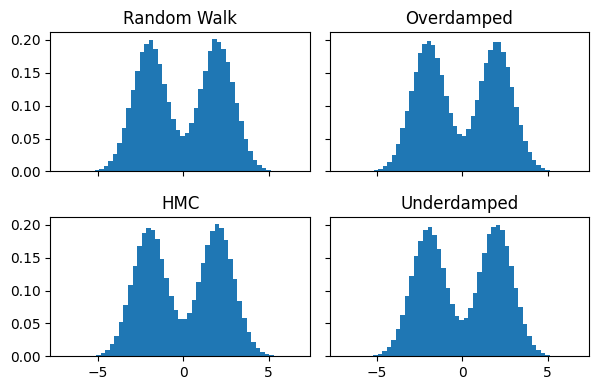

In [20]:
plot_summary(lambda samp, ax: mocat.hist_1d_samples(samp, ax=ax, dim=0));

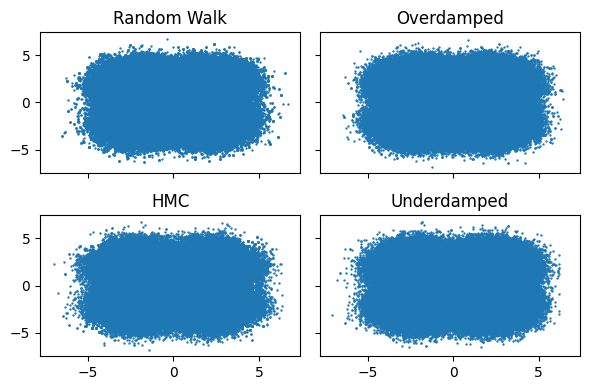

In [21]:
plot_summary(lambda samp, ax: mocat.plot_2d_samples(samp, ax=ax));

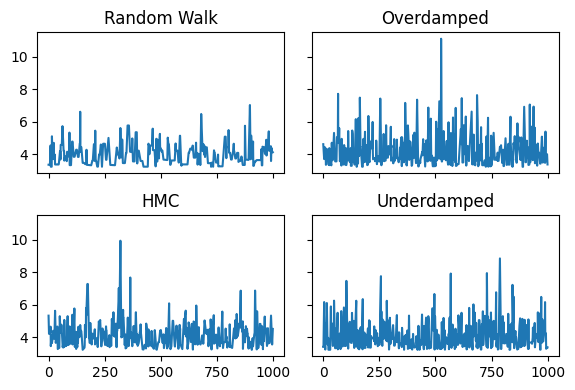

In [22]:
plot_summary(lambda samp, ax: mocat.trace_plot(samp, ax=ax, last_n=1000));

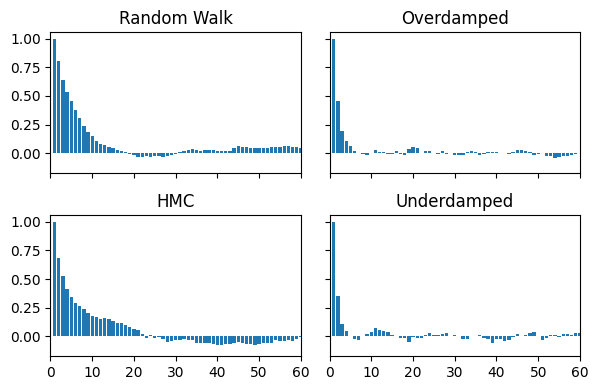

In [23]:
plot_summary(lambda samp, ax: mocat.autocorrelation_plot(samp, ax=ax, max_lag_plot=60));